In [ ]:
## This is a series of examples using the icanswim/cosmosis data science and machine learning repo

In [1]:
from model import FFNet, tv_model
from learning import Learn, Selector, Metrics
from dataset import SKDS, TVDS, CDataset, ImageDatasetStats, AsTensor, Squeeze, DType

from torch.optim import Adam
from torch.nn import MSELoss, CrossEntropyLoss
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision import transforms

In [2]:
## Example of generic/custom dataset and transforms
import numpy as np

class DummyDataset(CDataset):

    def load_data(self, boom='bust'):
        
        datadic = {1: {'feature_1': np.asarray([.04]),
                       'feature_2': np.asarray([.02]),
                       'feature_3': np.asarray(['c']),
                       'feature_4': np.asarray(['b','a']),
                       'feature_5': np.asarray([1.1])},
                   2: {'feature_1': np.asarray([.03]),
                       'feature_2': np.asarray([.01]),
                       'feature_3': np.asarray(['a','b','d']),
                       'feature_4': np.asarray(['d']),
                       'feature_5': np.asarray([1.2])}}
        
        print(boom)
        return datadic
    
class DummyTransform():
    def __call__(self, arr):
        return np.add(arr, 2)
    
class DummyTransformTwo():
    def __call__(self, arr):
        return np.multiply(arr, .1)
    
ds_params = {'train_params': {'features': ['feature_1','feature_5'],
                              'embeds': ['feature_3','feature_4'],
                              'targets': ['feature_2'],
                              'embed_lookup': {'a': 1, 'b': 2, 'c': 3, 'd': 4, '0': 0},
                              'transform': [DummyTransform(), DummyTransformTwo()],
                              'target_transform': [],
                              'pad': 4,
                              'do_not_pad': ['feature_1','feature_2','feature_3'],
                              'boom': 'bang'}}
    
d = DummyDataset(**ds_params['train_params'])
d[2]

bang
CDataset created...


(array([0.203, 0.32 , 0.2  , 0.2  , 0.2  ]),
 [array([1, 2, 4]), array([4, 0, 0, 0])],
 array([0.01]))

In [3]:
## Example of sklearn regression dataset wrapper
ds_params = {'train_params': {'features': ['X'],
                              'targets': ['y'],
                              'make': 'make_regression',
                              'sk_params': {'n_samples': 100,
                                            'n_features': 5},
                              'features_dtype': 'float32',
                              'targets_dtype': 'float32'}}

sk = SKDS(**ds_params['train_params'])

sk[1]

CDataset created...
SKDS make_regression created...


(array([-0.8135449 ,  0.7010371 , -0.4194758 , -0.41343555,  1.9365    ],
       dtype=float32),
 [],
 array([58.76622], dtype=float32))

In [4]:
## Example of sklearn classification dataset wrapper
ds_params = {'train_params': {'features': ['X'],
                              'targets': ['y'],
                              'make': 'make_classification',
                              'features_dtype': 'float32',
                              'targets_dtype': 'int64',
                              'sk_params': {'n_samples': 100,
                                            'n_features': 10,
                                            'n_informative': 8,
                                            'n_clusters_per_class': 2,
                                            'flip_y': 0.05,
                                            'class_sep': 0.01,
                                            'n_classes': 4}}}

sk = SKDS(**ds_params['train_params'])

sk[1]

CDataset created...
SKDS make_classification created...


(array([ 0.1404096 , -0.10759404, -1.8037606 , -0.21233381, -0.678941  ,
        -2.3716967 , -0.8435834 ,  1.8079827 ,  1.506103  ,  1.5220646 ],
       dtype=float32),
 [],
 array([0]))

In [5]:
## Example of torchvision wrapper
ds_params={'dataset': 'MNIST',
           'tv_params': {'root': './data/',
                         'train': True,
                         'download': True,
                         'transform': transforms.Compose([
                                           transforms.Resize(224)]),
                         'target_transform': None}}

tvds = TVDS(**ds_params)
tvds[1]

CDataset created...
TVDS created...


(<PIL.Image.Image image mode=L size=224x224 at 0x7FE8C0CF1520>, [], 0)

In [ ]:
## Example of torchvision dataset wrapper with PIL transform
ds_params={'dataset': 'MNIST',
           'tv_params': {'root': './data/',
                         'train': True,
                         'download': True,
                         'transform': transforms.Compose([
                                           transforms.Resize(224)]),
                         'target_transform': None}}

tvds = TVDS(**ds_params)
ids = ImageDatasetStats(tvds)

print('mean: ', ids.stats.mean)
print('stddev: ', ids.stats.stddev)

#mean: 33.3/255 = .13
#stddev: 73.7/255 = .29

CDataset created...
SKDS make_regression created...
FFNet model loaded...
CModel loaded...
running model on cpu...
learning time: 0:00:02.932938
epoch: 0, lr: 0.01
train loss: 653524.9618055555, val loss: 623250.9875
sklearn train metric: 0, sklearn validation metric: 0
learning time: 0:00:13.655353
epoch: 8, lr: 0.01
train loss: 15843.774703414352, val loss: 14256.4306640625
sklearn train metric: 0, sklearn validation metric: 0
test loss: 14609.406640625
learning time: 0:00:15.271369
sklearn test metric: 
0 



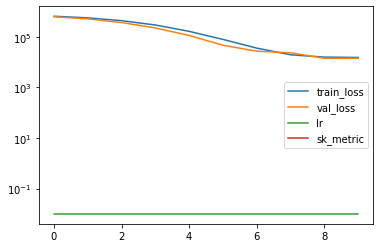

In [6]:
## Example sklearn regression dataset wrapper with custom model
model_params = {'D_in': 256, 
                'H': 512, 
                'D_out': 1, 
                'model_name': 'funnel',
                'embed_params': None}

ds_params = {'train_params': {'features': ['X'],
                              'targets': ['y'],
                              'features_dtype': 'float32',
                              'targets_dtype': 'float32',
                              'make': 'make_regression',
                              'transform': [],
                              'sk_params': {'n_samples': 10000,
                                            'n_features': 256,
                                            'n_informative': 200}}}
             
metrics_params = {'report_interval': 10}                         
             
opt_params = {'lr': 0.01}

crit_params = {'reduction': 'sum'}

sample_params = {'set_seed': 88,
                 'splits': (.7,.15)}

sched_params = {'factor': .5,
                'patience': 2,
                'cooldown': 2}

l = Learn([SKDS], 
          FFNet,
          Metrics=Metrics,
          Sampler=Selector, 
          Optimizer=Adam, 
          Scheduler=ReduceLROnPlateau, 
          Criterion=MSELoss,
          model_params=model_params, ds_params=ds_params, sample_params=sample_params,
          opt_params=opt_params, sched_params=sched_params, crit_params=crit_params,
          metrics_params=metrics_params, 
          batch_size=256, epochs=10, gpu=False)

CDataset created...
SKDS make_classification created...
FFNet model loaded...
CModel loaded...
running model on gpu...
learning time: 0:00:00.821606
epoch: 0, lr: 0.01
train loss: 1.4169223794230708, val loss: 1.412109830162742
sklearn train metric: 0.5105549662696837, sklearn validation metric: 0.5009897144795196
test loss: 1.0814110257408835
learning time: 0:00:08.704129
sklearn test metric: 
0.8857456929362932 



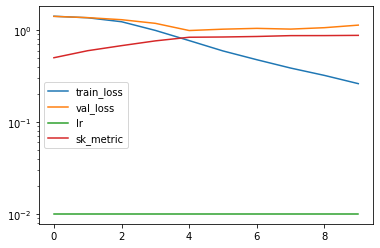

In [8]:
## Example sklearn classification dataset and metrics wrapper with custom model
model_params = {'D_in': 256, 
                'H': 192, 
                'D_out': 4, 
                'model_name': 'funnel',
                'embed_params': None}

ds_params = {'train_params': {'features': 'X',
                              'targets': 'y',
                              'features_dtype': 'float32',
                              'targets_dtype': 'int64',
                              'make': 'make_classification',
                              'sk_params': {'n_samples': 10000,
                                            'n_features': 256,
                                            'n_informative': 200,
                                            'n_clusters_per_class': 3,
                                            'flip_y': 0.05,
                                            'class_sep': 0.1,
                                            'n_classes': 4}}}
                                     
metrics_params = {'report_interval': 10, 
                  'sk_metric_name': 'roc_auc_score', 
                  'sk_params': {'average': 'macro',
                                'multi_class': 'ovr'}}

opt_params = {'lr': 0.01}

crit_params = {'reduction': 'sum'}

sample_params = {'set_seed': 88,
                 'splits': (.7,.15)}

sched_params = {'factor': .5,
                'patience': 5,
                'cooldown': 5}

l = Learn([SKDS], 
          FFNet, 
          Sampler=Selector,
          Metrics=Metrics,
          Optimizer=Adam, 
          Scheduler=ReduceLROnPlateau, 
          Criterion=CrossEntropyLoss,
          model_params=model_params, ds_params=ds_params, 
          sample_params=sample_params, opt_params=opt_params, 
          sched_params=sched_params, crit_params=crit_params,
          metrics_params=metrics_params,
          batch_size=128, epochs=10, squeeze_y=True)

Files already downloaded and verified
CDataset created...
TVDS created...
Files already downloaded and verified
CDataset created...
TVDS created...
TorchVision model resnet18 loaded...
running model on gpu...
learning time: 0:00:12.603938
epoch: 0, lr: 0.01
train loss: 2.3100991263389585, val loss: 2.065327803934774
sklearn train metric: 0.6354927825064693, sklearn validation metric: 0.7109637511273627
learning time: 0:00:24.793124
epoch: 1, lr: 0.01
train loss: 2.0202722191810607, val loss: 1.9716532576468684
sklearn train metric: 0.7206444459974943, sklearn validation metric: 0.7681938930948344
learning time: 0:00:36.979466
epoch: 2, lr: 0.01
train loss: 1.8841435151100159, val loss: 1.802508856019666
sklearn train metric: 0.7715873427908354, sklearn validation metric: 0.8071353205500857
learning time: 0:00:49.248535
epoch: 3, lr: 0.01
train loss: 1.81092453956604, val loss: 1.7469194781395696
sklearn train metric: 0.79163365940181, sklearn validation metric: 0.8215485142453518
learn

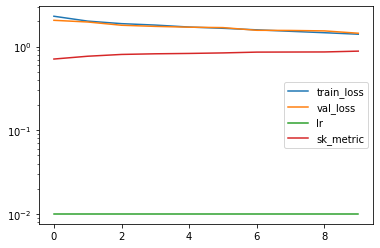

In [9]:
## Example torchvision dataset, transforms and model wrapper
model_params = {'model_name': 'resnet18',
                'in_channels': 3,
                'tv_params': {'num_classes': 10},
                'embed_params': None}

ds_params={'train_params': {'dataset': 'CIFAR10',
                            'tv_params': {'root': './data/',
                                          'train': True,
                                          'download': True,
                                          'transform': transforms.Compose([
                                                           transforms.RandomRotation(10),
                                                           transforms.Resize(224),
                                                           transforms.ToTensor()]),
                                          'target_transform': None,
                                          'download': True}},
           'test_params': {'dataset': 'CIFAR10',
                           'tv_params': {'root': './data/',
                                         'train': False,
                                         'download': True,
                                         'transform': transforms.Compose([
                                                         transforms.Resize(224),
                                                         transforms.ToTensor()]),
                                         'target_transform': None,
                                         'download': True}}}

metrics_params = {'report_interval': 10, 
                  'sk_metric_name': 'roc_auc_score', 
                  'sk_params': {'average': 'macro',
                                'multi_class': 'ovr'}}

opt_params = {'lr': 0.01}

crit_params = {'reduction': 'sum'}

sample_params = {'set_seed': 88,
                 'splits': (.8,),
                 'subset': .1}

sched_params = {'factor': .5,
                'patience': 1,
                'cooldown': 1}

l = Learn([TVDS,TVDS], 
          tv_model, 
          Selector, 
          Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=CrossEntropyLoss, 
          model_params=model_params, ds_params=ds_params, sample_params=sample_params, 
          opt_params=opt_params, sched_params=sched_params, crit_params=crit_params,
          metrics_params=metrics_params, 
          batch_size=16, epochs=10)

In [ ]:
## Example torchvision dataset and model wrapper
model_params = {'model_name': 'resnext50_32x4d',
                'in_channels': 3,
                'tv_params': {'num_classes': 10},
                'embed_params': None}

ds_params={'train_params': {'dataset': 'CIFAR10',
                            'tv_params': {'root': './data/',
                                          'train': True,
                                          'transform': transforms.Compose([
                                                       transforms.RandomRotation(10),
                                                       transforms.Resize(256),
                                                       transforms.ToTensor()]),
                                          'target_transform': None}},
           'test_params': {'dataset': 'CIFAR10',
                           'tv_params': {'root': './data/',
                                         'train': False,
                                         'transform': transforms.Compose([
                                                      transforms.Resize(256),
                                                      transforms.ToTensor()]),
                                         'target_transform': None}}}

metrics_params = {'report_interval': 10, 
                  'sk_metric_name': 'roc_auc_score', 
                  'sk_params': {'average': 'macro',
                                'multi_class': 'ovr'}}

opt_params = {'lr': 0.01}

crit_params = {'reduction': 'sum'}

sample_params = {'set_seed': 88,
                 'splits': (.8,),
                 'subset': .1}

sched_params = {'factor': .5,
                'patience': 2,
                'cooldown': 2}

l = Learn([TVDS,TVDS], 
          tv_model, 
          Selector, 
          Optimizer=Adam, 
          Scheduler=ReduceLROnPlateau, 
          Criterion=CrossEntropyLoss, 
          model_params=model_params, ds_params=ds_params, 
          sample_params=sample_params, opt_params=opt_params, 
          sched_params=sched_params, crit_params=crit_params,
          metrics_params=metrics_params,
          batch_size=16, epochs=10)

CDataset created...
TVDS created...
CDataset created...
TVDS created...
TorchVision model resnext50_32x4d loaded...
running model on gpu...
learning time: 0:01:02.498780
epoch: 0, lr: 0.01
train loss: 2.657156445980072, val loss: 2.1302882125300746
sklearn train metric: 0.5546015955334854, sklearn validation metric: 0.6867644739862593
learning time: 0:02:05.892752
epoch: 1, lr: 0.01
train loss: 2.0839722723960876, val loss: 2.008015340374362
sklearn train metric: 0.6918476144704379, sklearn validation metric: 0.7504224572336982
learning time: 0:03:09.241042
epoch: 2, lr: 0.01
train loss: 1.9953033900260926, val loss: 1.9468813519324026
sklearn train metric: 0.7319606702887708, sklearn validation metric: 0.7618090753471106
